## Project Objective
For this project I chose a **Healthcaere Providers** dataset from Kaggle. Data set has about 100k entries but I'll work with only 30K, for ease of computation.

I will attempt to cluster these providers into multiple Segments.

I will attempt four different clustering techniques; KMeans, DBSCAN, Agglomerative Clustering and Guassian Mixture Models.

I will evaluate a clustering techniques using the Silhouete score and pick what I consider to be the best.

I will perform some EDA to investigate the characteristics of each cluster, with respect to their charges, to see if there may be anomalies.

In [1]:
##from google.colab import drive
##drive.mount('/content/drive')

In [57]:
!pip install umap-learn

In [58]:
%matplotlib inline
import math
import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
#from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import  classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn import datasets, metrics
#import plotly.express as px

import warnings

In [180]:
#read csv file
df = pd.read_csv('Healthcare_Providers.csv')
df = df[0:29999]

## About the dataset

In [181]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29999 entries, 0 to 29998
Data columns (total 27 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   index                                                     29999 non-null  int64  
 1   National Provider Identifier                              29999 non-null  int64  
 2   Last Name/Organization Name of the Provider               29999 non-null  object 
 3   First Name of the Provider                                28726 non-null  object 
 4   Middle Initial of the Provider                            21238 non-null  object 
 5   Credentials of the Provider                               27817 non-null  object 
 6   Gender of the Provider                                    28726 non-null  object 
 7   Entity Type of the Provider                               29999 non-null  object 
 8   Street Address 1

In [182]:
df.head(3)

,index,National Provider Identifier,Last Name/Organization Name of the Provider,First Name of the Provider,Middle Initial of the Provider,Credentials of the Provider,Gender of the Provider,Entity Type of the Provider,Street Address 1 of the Provider,Street Address 2 of the Provider,...,HCPCS Code,HCPCS Description,HCPCS Drug Indicator,Number of Services,Number of Medicare Beneficiaries,Number of Distinct Medicare Beneficiary/Per Day Services,Average Medicare Allowed Amount,Average Submitted Charge Amount,Average Medicare Payment Amount,Average Medicare Standardized Amount
0,8774979,1891106191,UPADHYAYULA,SATYASREE,NaN,M.D.,F,I,1402 S GRAND BLVD,FDT 14TH FLOOR,...,99223,"Initial hospital inpatient care, typically 70 ...",N,27,24,27,200.58777778,305.21111111,157.26222222,160.90888889
1,3354385,1346202256,JONES,WENDY,P,M.D.,F,I,2950 VILLAGE DR,NaN,...,G0202,"Screening mammography, bilateral (2-view study...",N,175,175,175,123.73,548.8,118.83,135.31525714
2,3001884,1306820956,DUROCHER,RICHARD,W,DPM,M,I,20 WASHINGTON AVE,STE 212,...,99348,"Established patient home visit, typically 25 m...",N,32,13,32,90.65,155,64.4396875,60.5959375


Contains a lot of unnecessary variables, of which I will drop and rename the rest in the proper format.

In [183]:
#drop unneeded columns
df = df.drop(['index', 'National Provider Identifier',
                 'Last Name/Organization Name of the Provider', 
                 'First Name of the Provider',	'Middle Initial of the Provider',
                 'Street Address 1 of the Provider',	'Street Address 2 of the Provider',
                  'Zip Code of the Provider', 'HCPCS Description'], axis=1)

#rename columns
df.rename(columns={'Credentials of the Provider':'Provider_Credentials','Gender of the Provider':'Gender',
                    'Entity Type of the Provider':'Entity_Type', 'City of the Provider':'City',
                    'State Code of the Provider':'State',
                    'Country Code of the Provider':'Country_Code','Provider Type':'Practice_Type',
                    'Medicare Participation Indicator':'Med_Participatn_Indicator',
                    'Place of Service':'Place_of_Service','HCPCS Code':'HCPCS_Code',
                    'HCPCS Drug Indicator':'HCPCS_Drug_Indicator', 'Number of Services':'Number_of_Services',
                    'Number of Medicare Beneficiaries':'Number_of_Med_Ben', 
                    'Number of Distinct Medicare Beneficiary/Per Day Services':'Unique_Med_Ben_Per_Day_Services',
                    'Average Medicare Allowed Amount':'Avg_Med_Allowed_Amnt',
                    'Average Submitted Charge Amount':'Avg_Submtd_Charge_Amnt',
                    'Average Medicare Payment Amount':'Avg_Med_Paymnt_Amnt',
                    'Average Medicare Standardized Amount':'Avg_Med_Stndrdzd_Amnt'}, inplace=True)

In [184]:
df.head(4)

,Provider_Credentials,Gender,Entity_Type,City,State,Country_Code,Practice_Type,Med_Participatn_Indicator,Place_of_Service,HCPCS_Code,HCPCS_Drug_Indicator,Number_of_Services,Number_of_Med_Ben,Unique_Med_Ben_Per_Day_Services,Avg_Med_Allowed_Amnt,Avg_Submtd_Charge_Amnt,Avg_Med_Paymnt_Amnt,Avg_Med_Stndrdzd_Amnt
0,M.D.,F,I,SAINT LOUIS,MO,US,Internal Medicine,Y,F,99223,N,27,24,27,200.58777778,305.21111111,157.26222222,160.90888889
1,M.D.,F,I,FAYETTEVILLE,NC,US,Obstetrics & Gynecology,Y,O,G0202,N,175,175,175,123.73,548.8,118.83,135.31525714
2,DPM,M,I,NORTH HAVEN,CT,US,Podiatry,Y,O,99348,N,32,13,32,90.65,155,64.4396875,60.5959375
3,MD,M,I,KANSAS CITY,MO,US,Internal Medicine,Y,O,81002,N,20,18,20,3.5,5,3.43,3.43


Check for missing variables.

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29999 entries, 0 to 29998
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Provider_Credentials             27817 non-null  object
 1   Gender                           28726 non-null  object
 2   Entity_Type                      29999 non-null  object
 3   City                             29999 non-null  object
 4   State                            29999 non-null  object
 5   Country_Code                     29999 non-null  object
 6   Practice_Type                    29999 non-null  object
 7   Med_Participatn_Indicator        29999 non-null  object
 8   Place_of_Service                 29999 non-null  object
 9   HCPCS_Code                       29999 non-null  object
 10  HCPCS_Drug_Indicator             29999 non-null  object
 11  Number_of_Services               29999 non-null  object
 12  Number_of_Med_Ben               

In [85]:
df.isnull().sum()*100/df.shape[0]

Provider_Credentials               7.273576
Gender                             4.243475
Entity_Type                        0.000000
City                               0.000000
State                              0.000000
Country_Code                       0.000000
Practice_Type                      0.000000
Med_Participatn_Indicator          0.000000
Place_of_Service                   0.000000
HCPCS_Code                         0.000000
HCPCS_Drug_Indicator               0.000000
Number_of_Services                 0.000000
Number_of_Med_Ben                  0.000000
Unique_Med_Ben_Per_Day_Services    0.000000
Avg_Med_Allowed_Amnt               0.000000
Avg_Submtd_Charge_Amnt             0.000000
Avg_Med_Paymnt_Amnt                0.000000
Avg_Med_Stndrdzd_Amnt              0.000000
dtype: float64

In [8]:
#unique values of each column
for column_name in df.columns:
    print("Unique values in column {} are: {}".format(column_name, df[column_name].unique()))

Unique values in column Provider_Credentials are: ['M.D.' 'DPM' 'MD' ... 'DNP FNP-BC' 'MRCP, MD' 'PT,DPTATC']
Unique values in column Gender are: ['F' 'M' nan]
Unique values in column Entity_Type are: ['I' 'O']
Unique values in column City are: ['SAINT LOUIS' 'FAYETTEVILLE' 'NORTH HAVEN' ... 'SALIDA' 'PLATTSBURG'
 'HOOPER BAY']
Unique values in column State are: ['MO' 'NC' 'CT' 'FL' 'VA' 'CA' 'CO' 'PA' 'AZ' 'KY' 'DC' 'WA' 'TX' 'NJ'
 'MD' 'LA' 'OH' 'NY' 'GU' 'IL' 'OK' 'SC' 'MA' 'GA' 'IN' 'ME' 'MT' 'WI'
 'AL' 'OR' 'NH' 'KS' 'MI' 'ID' 'MS' 'MN' 'TN' 'IA' 'NE' 'AK' 'ZZ' 'VT'
 'NV' 'AR' 'WV' 'HI' 'RI' 'SD' 'PR' 'UT' 'NM' 'ND' 'DE' 'WY' 'VI' 'AE'
 'AP' 'AA']
Unique values in column Country_Code are: ['US' 'JP' 'DE' 'TR']
Unique values in column Practice_Type are: ['Internal Medicine' 'Obstetrics & Gynecology' 'Podiatry'
 'Physical Therapist in Private Practice' 'Diagnostic Radiology'
 'Family Practice' 'Clinical Laboratory' 'General Surgery'
 'Pain Management' 'Physician Assistant' 'Cardiolo

In [170]:
#convert dtypes from object to numeric (integers and floats)
def remove_comma(x):
  return x.replace(",", "")


df['Number_of_Services'] = pd.to_numeric(df['Number_of_Services']
                                           .apply(lambda x: remove_comma(x)), 
                                           errors='ignore', downcast='integer' )
df['Number_of_Med_Ben'] = pd.to_numeric(df['Number_of_Med_Ben']
                                           .apply(lambda x: remove_comma(x)), 
                                           errors='ignore', downcast='integer')
df['Unique_Med_Ben_Per_Day_Services'] = pd.to_numeric(df['Unique_Med_Ben_Per_Day_Services']
                                           .apply(lambda x: remove_comma(x)), 
                                           errors='ignore', downcast='integer')
df['Avg_Med_Allowed_Amnt'] = pd.to_numeric(df['Avg_Med_Allowed_Amnt']
                                           .apply(lambda x: remove_comma(x)), 
                                           errors='ignore', downcast='float')
df['Avg_Submtd_Charge_Amnt'] = pd.to_numeric(df['Avg_Submtd_Charge_Amnt']
                                           .apply(lambda x: remove_comma(x)), 
                                           errors='ignore', downcast='float')
df['Avg_Med_Paymnt_Amnt'] = pd.to_numeric(df['Avg_Med_Paymnt_Amnt']
                                           .apply(lambda x: remove_comma(x)), 
                                           errors='ignore', downcast='float')
df['Avg_Med_Stndrdzd_Amnt'] = pd.to_numeric(df['Avg_Med_Stndrdzd_Amnt']
                                           .apply(lambda x: remove_comma(x)), 
                                           errors='ignore', downcast='float')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Provider_Credentials             92791 non-null   object 
 1   Gender                           95746 non-null   object 
 2   Entity_Type                      100000 non-null  object 
 3   City                             100000 non-null  object 
 4   State                            100000 non-null  object 
 5   Country_Code                     100000 non-null  object 
 6   Practice_Type                    100000 non-null  object 
 7   Med_Participatn_Indicator        100000 non-null  object 
 8   Place_of_Service                 100000 non-null  object 
 9   HCPCS_Code                       100000 non-null  object 
 10  HCPCS_Drug_Indicator             100000 non-null  object 
 11  Number_of_Services               100000 non-null  float64
 12  Num

In [185]:
#define a function for preprocessing the data
def Preprocessing(data):

  #replace missing values with the mode value
  data['Provider_Credentials'] = data['Provider_Credentials'].fillna(data['Provider_Credentials'].mode()[0])
  data['Gender'] = data['Gender'].fillna(data['Gender'].mode()[0])

  #binary encoding
  data['Gender'] = data['Gender'].apply(lambda x: 1 if x=='F' else 0)
  data['Entity_Type'] = data['Entity_Type'].apply(lambda x: 1 if x=='I' else 0)
  data['Med_Participatn_Indicator'] = data['Med_Participatn_Indicator'].apply(lambda x: 1 if x=='Y' else 0)
  data['Place_of_Service'] = data['Place_of_Service'].apply(lambda x: 1 if x=='F' else 0)
  data['HCPCS_Drug_Indicator'] = data['HCPCS_Drug_Indicator'].apply(lambda x: 1 if x=='Y' else 0)

  #converting to numerical using LabelEncoder
  #columns to be converted to numerical
  cols = data[['Provider_Credentials','City','State','Country_Code','Practice_Type','HCPCS_Code']]
  
  #fitting the LabelEncoder
  for col in cols:
    label_encoder = LabelEncoder()
    data[col] = label_encoder.fit_transform(data[col])
  
  #scale
  scaler = StandardScaler()
  data_std = scaler.fit_transform(data)
  data = pd.DataFrame(data_std, columns=data.columns)

  return data

## Preprocessing

In [63]:
df_proccesed = Preprocessing(df)
df_proccesed.head(4)

,Provider_Credentials,Gender,Entity_Type,City,State,Country_Code,Practice_Type,Med_Participatn_Indicator,Place_of_Service,HCPCS_Code,HCPCS_Drug_Indicator,Number_of_Services,Number_of_Med_Ben,Unique_Med_Ben_Per_Day_Services,Avg_Med_Allowed_Amnt,Avg_Submtd_Charge_Amnt,Avg_Med_Paymnt_Amnt,Avg_Med_Stndrdzd_Amnt
0,-0.488378,1.560617,0.210512,1.005377,-0.021800,0.009429,0.024980,0.017323,1.267594,0.799600,-0.25466,-0.098088,-0.087240,-0.108617,0.337538,-0.043409,0.351023,0.355140
1,-0.488378,1.560617,0.210512,-0.730372,0.174709,0.009429,0.677179,0.017323,-0.788896,1.011118,-0.25466,-0.029083,0.120910,0.034752,0.073201,0.169859,0.180592,0.244456
2,-1.284247,-0.640772,0.210512,0.482881,-1.266357,0.009429,1.429717,0.017323,-0.788896,0.885850,-0.25466,-0.095757,-0.102403,-0.103773,-0.040571,-0.174923,-0.060606,-0.078680
3,0.475848,-0.640772,0.210512,-0.197249,-0.021800,0.009429,0.024980,0.017323,-0.788896,-0.527010,-0.25466,-0.101352,-0.095511,-0.115398,-0.340306,-0.306251,-0.331159,-0.325903


In [12]:
df_proccesed.shape

(29999, 18)

In [126]:
#drop unneeded columns Kmeans to reduce dimensions for clustering algorithm
df2 = df_proccesed.copy()

In [127]:
#drop some more unenecassary variables 
df2 = df2.drop(['Provider_Credentials', 'Gender', 'Entity_Type', 'City','State',
                 'Country_Code', 'Practice_Type', 'HCPCS_Code' , 
                 'Place_of_Service'], axis=1) #, 'Unique_Med_Ben_Per_Day_Services''HCPCS_Drug_Indicator', 
                 #'Number_of_Services', 'Number_of_Med_Ben', 'Med_Participatn_Indicator',

df2.head(5)

,Med_Participatn_Indicator,HCPCS_Drug_Indicator,Number_of_Services,Number_of_Med_Ben,Unique_Med_Ben_Per_Day_Services,Avg_Med_Allowed_Amnt,Avg_Submtd_Charge_Amnt,Avg_Med_Paymnt_Amnt,Avg_Med_Stndrdzd_Amnt
0,0.017323,-0.25466,-0.098088,-0.087240,-0.108617,0.337538,-0.043409,0.351023,0.355140
1,0.017323,-0.25466,-0.029083,0.120910,0.034752,0.073201,0.169859,0.180592,0.244456
2,0.017323,-0.25466,-0.095757,-0.102403,-0.103773,-0.040571,-0.174923,-0.060606,-0.078680
3,0.017323,-0.25466,-0.101352,-0.095511,-0.115398,-0.340306,-0.306251,-0.331159,-0.325903
4,0.017323,-0.25466,-0.095291,-0.087240,-0.104742,-0.261133,-0.275608,-0.259720,-0.258319


*******************************************************************************************************************************

# Clustering

## **1. K-Means**

In [159]:
#choosing number of clusters by applying the elbow method

#max number of clusters
max_cluster = 21

#test K-Means cluster
kmeans_test = [KMeans(n_clusters=i, n_init=10) for i in range(1, max_cluster)]
inertias = [kmeans_test[i].fit(df2).inertia_ for i in range(len(kmeans_test))]

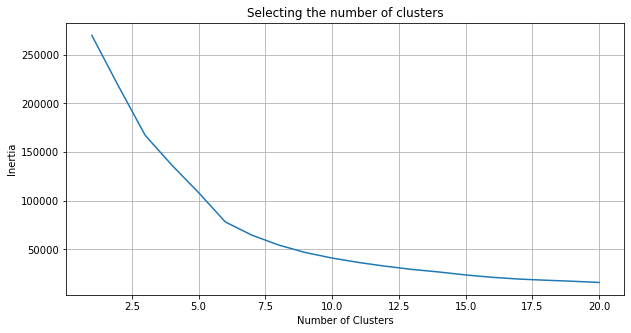

In [160]:
#Plotting the elbow graph to select the ideal number of clusters
plt.figure(figsize=(10,5))
plt.plot(range(1, max_cluster), inertias)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.title('Selecting the number of clusters')
plt.show()

From the elbow of the plot, I will choose 6 clusters for the KMeans.

In [163]:
#K-Means cluster using n_cluster = 10
kmeans = KMeans(n_clusters=6, n_init=10, random_state=123).fit(df2)

#label clusters
kmeans_labels = kmeans.labels_

print('There are {} clusters. They are: {}'.format(len(set(kmeans_labels)),set(kmeans_labels)))

There are 6 clusters. They are: {0, 1, 2, 3, 4, 5}


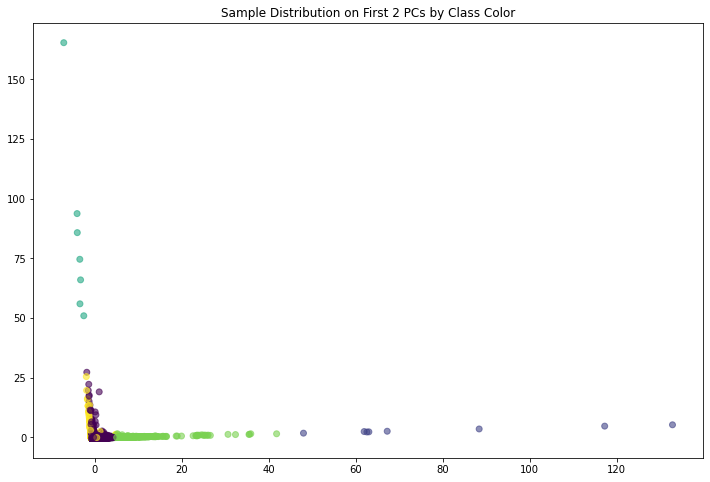

In [164]:
#dimensionality reduction with PCA to 2 components
pca = PCA(n_components=2, random_state = 123).fit_transform(df2)

#make dataframe for PC
pca_df = pd.DataFrame(pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = kmeans_labels

plt.figure(figsize=(12,8))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha = .6, c=kmeans_labels)
plt.title('Sample Distribution on First 2 PCs by Class Color')
plt.show()

In [167]:
#Calculate the silhouette score
print("The silhouette score of the KMeans solution: {}"
      .format(metrics.silhouette_score(df2, kmeans_labels, metric='euclidean')))

The silhouette score of the KMeans solution: 0.8244292281733173


## **DBSCAN Clustering**

In [157]:
# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=1, min_samples=5).fit(df2)

#assign labels to the cluster
cluster = dbscan_cluster.labels_

print('There are {} clusters. They are: {}'.format(len(set(cluster)),set(cluster)))

There are 6 clusters. They are: {0, 1, 2, 3, 4, -1}


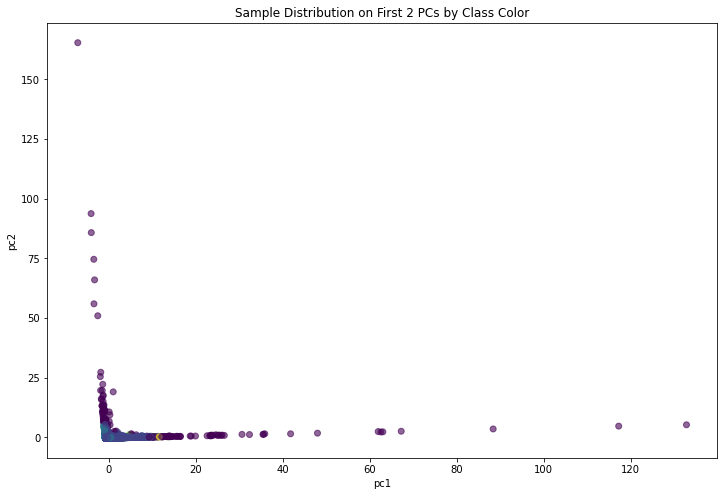

In [158]:
pca = PCA(n_components=2).fit_transform(df2)
pca = pd.DataFrame(pca)
pca.columns = ['pc1', 'pc2']

plt.figure(figsize=(12,8))
plt.title('Sample Distribution on First 2 PCs by Class Color')
plt.scatter(pca['pc1'], pca['pc2'], alpha = .6, c=cluster)
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.show()

In [134]:
#Calculate the silhouette score
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(df2, cluster, metric='euclidean')))

The silhouette score of the DBSCAN solution: 0.799904016462423


## Agglomerative Clustering

In [135]:
# Defining the agglomerative clustering and Fitting model
agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=3).fit(df2)
#get label
agg_cluster_labels = agg_cluster.labels_

print('There are {} clusters. They are: {}'.format(len(set(agg_cluster_labels)),set(agg_cluster_labels)))

There are 3 clusters. They are: {0, 1, 2}


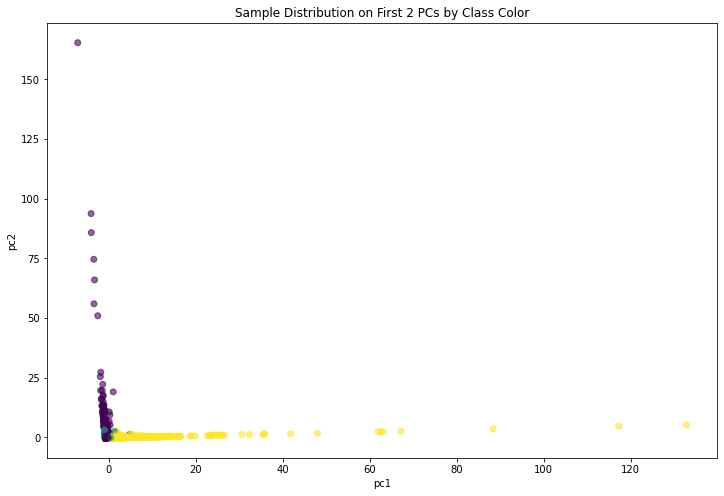

In [136]:
pca = PCA(n_components=2).fit_transform(df2)
pca = pd.DataFrame(pca)
pca.columns = ['pc1', 'pc2']

plt.figure(figsize=(12,8))
plt.title('Sample Distribution on First 2 PCs by Class Color')
plt.scatter(pca['pc1'], pca['pc2'], alpha = .6, c=agg_cluster_labels)
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.show()

In [138]:
#Calculate the silhouette score
print("The silhouette score of the Agglomerative clustering solution: {}"
      .format(metrics.silhouette_score(df2, agg_cluster_labels, metric='euclidean')))

The silhouette score of the Agglomerative clustering solution: 0.5080214164291569


## Gaussian Mixture Models (GMM)

In [173]:
# Defining the GMM clustering
gmm = GaussianMixture(n_components=6, random_state=123).fit(df2)

#label clusters
gmm_cluster = gmm.predict(df2)

print('There are {} clusters. They are: {}'.format(len(set(gmm_cluster)),set(gmm_cluster)))

There are 6 clusters. They are: {0, 1, 2, 3, 4, 5}


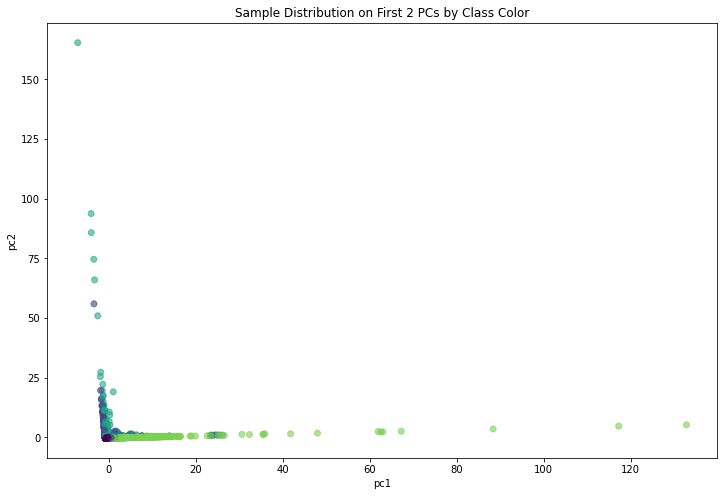

In [174]:
pca = PCA(n_components=2).fit_transform(df2)
pca = pd.DataFrame(pca)
pca.columns = ['pc1', 'pc2']

plt.figure(figsize=(12,8))
plt.title('Sample Distribution on First 2 PCs by Class Color')
plt.scatter(pca['pc1'], pca['pc2'], alpha = .6, c=gmm_cluster)
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.show()

In [175]:
#Calculate the silhouette score
print("The silhouette score of the GMM solution: {}"
      .format(metrics.silhouette_score(df2, gmm_cluster, metric='euclidean')))

The silhouette score of the GMM solution: 0.38555690689805794


_______________________________________________________________________________________________________________________________

## Evaluating the Clusters

Kmeans => 6 Clusters, 0.824 silhouette score

DBSCAN => 6 Clusters, 0.800 silhouette score

Agglomerative => 3 Clusters, 0.508 silhouette score

GMM => 6 Clusters, 0.386 silhouette score

Looking at the silhouette scores, KMeans had the highest score of 0.824 for 6 clusters. GMM clustering performed the worst with a score of 0.386 with 6 clusters.

I will go with Kmeans cluster, since it had the best silhouette score.

_______________________________________________________________________________________________________________________________

In [171]:
#add the cluster assignments to the original dataframe
df['Clusters'] = kmeans_labels

In [50]:
df.head(4)

,Provider_Credentials,Gender,Entity_Type,City,State,Country_Code,Practice_Type,Med_Participatn_Indicator,Place_of_Service,HCPCS_Code,HCPCS_Drug_Indicator,Number_of_Services,Number_of_Med_Ben,Unique_Med_Ben_Per_Day_Services,Avg_Med_Allowed_Amnt,Avg_Submtd_Charge_Amnt,Avg_Med_Paymnt_Amnt,Avg_Med_Stndrdzd_Amnt,Clusters
0,M.D.,F,I,SAINT LOUIS,MO,US,Internal Medicine,Y,F,99223,N,27.0,24,27,200.587784,305.211121,157.262222,160.908890,0
1,M.D.,F,I,FAYETTEVILLE,NC,US,Obstetrics & Gynecology,Y,O,G0202,N,175.0,175,175,123.730003,548.799988,118.830002,135.315262,0
2,DPM,M,I,NORTH HAVEN,CT,US,Podiatry,Y,O,99348,N,32.0,13,32,90.650002,155.000000,64.439690,60.595936,0
3,MD,M,I,KANSAS CITY,MO,US,Internal Medicine,Y,O,81002,N,20.0,18,20,3.500000,5.000000,3.430000,3.430000,0


In [172]:
#Save as csv
df.to_csv('clustered_Healthcare_Providers.csv', index=False)S